## Notebook for statistical analysis of the "hydrothermal methane" setup

Figures produced here are obtainable through the makefigures script

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize as scopt
import scipy.stats as stats
import scipy.integrate as scint
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
## Plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import seaborn as sns

# Custom imports
import pyEnceladus.universal_htv as uhtv
import pyEnceladus.data_htv as dhtv
import pyEnceladus.physical as phc
import pyEnceladus.plot_tools as cplt
from pyEnceladus.biosims import makePriors, makeOnePrior
from pyEnceladus.plot_abc import confusion_format
import pyEnceladus.simulation_qstar as smqs
import pyEnceladus.stats_analysis as homestats
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import os

mpl.rc('axes', labelsize=7)
mpl.rc('legend', fontsize=7)
mpl.rc('xtick', labelsize=5.5)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=5.5)

labelsDict = {'FH2':r'$\Phi_{\mathregular{H_2}}$','FCO2':r'$\Phi_{\mathregular{CO_2}}$','FCH4':r'$\Phi_{\mathregular{CH_4}}$','R1':r'$\mathregular{H_2}:\mathregular{CH_4}$','R2':r'$R_2$'}

palette = sns.color_palette('colorblind')

In [2]:
## load simulations and observations
dirname = 'hydrothermal_methane'
rootdir = os.path.join('data',dirname)
priors = pd.read_csv(os.path.join(rootdir,dirname+'.prior.csv'),delimiter=';',index_col=0)
outcomes = pd.read_csv(os.path.join(rootdir,'000/core_batch_000raw.csv'),delimiter=';',index_col=0)

observations    = pd.read_csv('data/observations/observations.csv',delimiter=';',index_col=0)
logobservations = pd.read_csv('data/observations/logobservations.csv',delimiter=';',index_col=0)
observation     = np.load('data/observations/observation.npy',allow_pickle=True)

reftable_data = np.load(os.path.join(rootdir,"reftable_data_standard.npy"),allow_pickle=True).item()
reftable_ref = np.load(os.path.join(rootdir,"reftable_ref_standard.npy"),allow_pickle=True)
testtable_data = np.load(os.path.join(rootdir,"testtable_data_standard.npy"),allow_pickle=True).item()
testtable_ref = np.load(os.path.join(rootdir,"testtable_ref_standard.npy"),allow_pickle=True)

total_table = pd.read_csv(os.path.join(rootdir,"total_table.csv"),delimiter=';')
training_df = pd.DataFrame(data=reftable_data)
test_df = pd.DataFrame(data=testtable_data)

bootstrap = np.load(os.path.join(rootdir,"bootstrap_standard.npy"),allow_pickle=True).item()

## Working on a simulation pool

In [3]:
# Translating raw outputs
timec = 60*60*24*365 # They have to be converted from s-1 into yr-1
observables_abiotic = pd.DataFrame(data={'FH2':outcomes['H2_ab']*timec,
                                         'FCH4':outcomes['CH4_ab']*timec,
                                         'R1':outcomes['H2_ab']/outcomes['CH4_ab']})
model = np.array(['uninhabitable','habitable'],dtype='str')[np.array(outcomes['H2']!=outcomes['H2_ab'],dtype=int)]
colors = {'uninhabitable':palette[0],
          'habitable':palette[1],
          'inhabited':palette[2]}
c1 = [colors[k] for k in model]
labels =  {'FH2' :'$\mathregular{H_2} $ escape rate \n $\Phi_{\mathregular{H_2} }$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCO2':'$\mathregular{CO_2}$ escape rate \n $\Phi_{\mathregular{CO_2}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCH4':'$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'R1':'gas ratio \n $\mathregular{H_2}:\mathregular{CH_4}$, ($\log_{10}$)',
           'R2':r'$R_2$',
           'H2f':'HF $\mathregular{H_2}$ \n $[\mathregular{H_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2f':'HF $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4f':'HF $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'H2o' :'Ocean $\mathregular{H_2}$ \n $[\mathregular{H_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2o':'Ocean $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4o':'Ocean $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'Tf':'HF temperature \n $T_f$ (K)'}

In [4]:
# Fraction of habitable simulations
np.sum(model=='habitable')/len(model)

0.32034

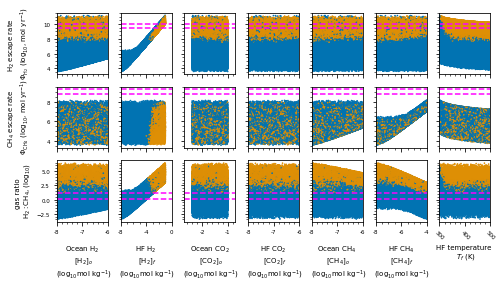

In [48]:
keys1 = list(priors.keys())
keys2 = list(observables_abiotic.keys())
rasterize_scatter = True
fig,axes = plt.subplots(ncols=len(keys1),nrows=len(keys2),figsize=(7,4))
for i in range(len(keys2)):
    for j in range(len(keys1)):
        if keys1[j] == 'Tf':
            axes[i,j].plot([300,500],[logobservations[keys2[i]]]*2,linestyle='--',color='magenta')
            axes[i,j].scatter(priors[keys1[j]],np.log10(observables_abiotic[keys2[i]]),s=0.5,c=c1,rasterized=rasterize_scatter)
            axes[i,j].set_xlim(300,500)
            axes[i,j].set_xticks([300,400,500])
            axes[i,j].set_xticklabels(['300','400','500'],rotation=-45)
        else:
            axes[i,j].plot([-8,0],[logobservations[keys2[i]]]*2,linestyle='--',color='magenta')
            axes[i,j].scatter(np.log10(priors[keys1[j]]),np.log10(observables_abiotic[keys2[i]]),s=0.5,c=c1,rasterized=rasterize_scatter)
            if keys1[j] in ['H2o','CO2f','CH4o']:
                axes[i,j].set_xticks([-8,-7,-6])
                axes[i,j].set_xticklabels(['-8','-7','-6'])
                axes[i,j].set_xlim(-8,-6)
            elif keys1[j] == 'CH4f':
                axes[i,j].set_xticks([-8,-6,-4])
                axes[i,j].set_xticklabels(['-8','-6','-4'])
                axes[i,j].set_xlim(-8,-4)
            elif keys1[j] == 'CO2o':
                axes[i,j].set_xticks([-2,-1])
                axes[i,j].set_xticklabels(['-2','-1'])
                axes[i,j].set_xlim(-2.7,-0.7)
            else:
                axes[i,j].set_xticks([-8,-4,0])
                axes[i,j].set_xticklabels(['-8','-4','0'])
                axes[i,j].set_xlim(-8,0)
        
        if j > 0:
            axes[i,j].set_yticklabels([])
        if i < len(keys2)-1:
            axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_ylabel(labels[keys2[i]])
        if i == len(keys2)-1:
            axes[i,j].set_xlabel(labels[keys1[j]])
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        axes[i,j].yaxis.set_minor_locator(AutoMinorLocator())
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2)
fig.align_labels(axes)
#plt.savefig(os.path.join(rootdir,'figures','inflow_ab.png'),dpi=400,bbox_inches='tight')
#plt.savefig('figures/inflow.svg',dpi=400)
plt.show()

In [5]:
# Building the 100% biotic (when habitable) table
observables_biotic = pd.DataFrame(data={'FH2':outcomes['H2']*timec,
                                        'FCH4':outcomes['CH4']*timec,
                                        'R1':outcomes['H2']/outcomes['CH4']})
model2 = np.array(['uninhabitable','inhabited'],dtype='str')[np.array(outcomes['H2']!=outcomes['H2_ab'],dtype=int)]
colors = {'uninhabitable':palette[0],
          'habitable':palette[1],
          'inhabited':palette[2]}
c2 = [colors[k] for k in model2]
labels =  {'FH2' :'$\mathregular{H_2} $ escape rate \n $\Phi_{\mathregular{H_2} }$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCO2':'$\mathregular{CO_2}$ escape rate \n $\Phi_{\mathregular{CO_2}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCH4':'$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'R1':'gas ratio \n $\mathregular{H_2}:\mathregular{CH_4}$, ($\log_{10}$)',
           'R2':r'$R_2$',
           'H2f':'HF $\mathregular{H_2}$ \n $[\mathregular{H_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2f':'HF $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4f':'HF $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'H2o' :'Ocean $\mathregular{H_2}$ \n $[\mathregular{H_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2o':'Ocean $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4o':'Ocean $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'Tf':'HF temperature \n $T_f$ (K)'}

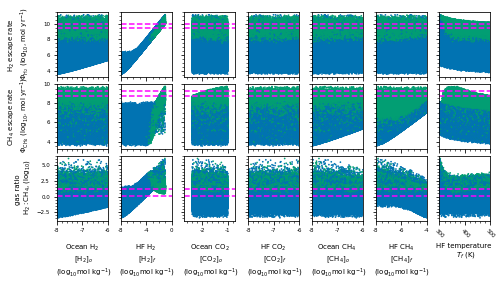

In [50]:
keys1 = list(priors.keys())
keys2 = list(observables_biotic.keys())
rasterize_scatter = True
fig,axes = plt.subplots(ncols=len(keys1),nrows=len(keys2),figsize=(7,4))
for i in range(len(keys2)):
    for j in range(len(keys1)):
        if keys1[j] == 'Tf':
            axes[i,j].plot([300,500],[logobservations[keys2[i]]]*2,linestyle='--',color='magenta')
            axes[i,j].scatter(priors[keys1[j]],np.log10(observables_biotic[keys2[i]]),s=0.5,c=c2,rasterized=rasterize_scatter)
            axes[i,j].set_xlim(300,500)
            axes[i,j].set_xticks([300,400,500])
            axes[i,j].set_xticklabels(['300','400','500'],rotation=-45)
        else:
            axes[i,j].plot([-8,0],[logobservations[keys2[i]]]*2,linestyle='--',color='magenta')
            axes[i,j].scatter(np.log10(priors[keys1[j]]),np.log10(observables_biotic[keys2[i]]),s=0.5,c=c2,rasterized=rasterize_scatter)
            if keys1[j] in ['H2o','CO2f','CH4o']:
                axes[i,j].set_xticks([-8,-7,-6])
                axes[i,j].set_xticklabels(['-8','-7','-6'])
                axes[i,j].set_xlim(-8,-6)
            elif keys1[j] == 'CH4f':
                axes[i,j].set_xticks([-8,-6,-4])
                axes[i,j].set_xticklabels(['-8','-6','-4'])
                axes[i,j].set_xlim(-8,-4)
            elif keys1[j] == 'CO2o':
                axes[i,j].set_xticks([-2,-1])
                axes[i,j].set_xticklabels(['-2','-1'])
                axes[i,j].set_xlim(-2.7,-0.7)
            else:
                axes[i,j].set_xticks([-8,-4,0])
                axes[i,j].set_xticklabels(['-8','-4','0'])
                axes[i,j].set_xlim(-8,0)
        
        if j > 0:
            axes[i,j].set_yticklabels([])
        if i < len(keys2)-1:
            axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_ylabel(labels[keys2[i]])
        if i == len(keys2)-1:
            axes[i,j].set_xlabel(labels[keys1[j]])
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        axes[i,j].yaxis.set_minor_locator(AutoMinorLocator())
            
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.align_labels(axes)
#plt.savefig(os.path.join(rootdir,'figures','inflow_bi.png'),dpi=400,bbox_inches='tight')
#plt.savefig('figures/inflow_biotic.svg',dpi=400,bbox_inches='tight')
#plt.savefig('figures/inflow_biotic.svg',dpi=400)
plt.show()

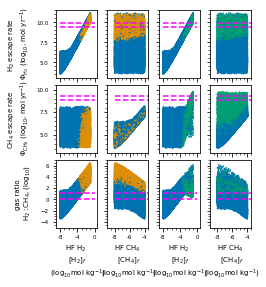

In [9]:
keys1 = ['H2f','CH4f']*2
keys2 = list(observables_biotic.keys())
rasterize_scatter = True
fig,axes = plt.subplots(ncols=len(keys1),nrows=len(keys2),figsize=(3.5,4))
for i in range(len(keys2)):
    for j in range(len(keys1)):
        if j > 1:
            table = observables_biotic
            c     = c2
        else:
            table = observables_abiotic
            c     = c1
        axes[i,j].plot([-8,0],[logobservations[keys2[i]]]*2,linestyle='--',color='magenta')
        axes[i,j].scatter(np.log10(priors[keys1[j]]),np.log10(table[keys2[i]]),s=0.5,c=c,rasterized=rasterize_scatter)
        if keys1[j] == 'CH4f':
            axes[i,j].set_xticks([-8,-6,-4])
            axes[i,j].set_xticklabels(['-8','-6','-4'])
            axes[i,j].set_xlim(-9,-3.5)
        else:
            axes[i,j].set_xticks([-8,-4,0])
            axes[i,j].set_xticklabels(['-8','-4','0'])
            axes[i,j].set_xlim(-9,0.5)
            
        if keys2[i] == 'FH2':
            axes[i,j].set_ylim(3,11.5)
            axes[i,j].set_yticks([5,7.5,10])
        if keys2[i] == 'FCH4':
            axes[i,j].set_ylim(3,10.5)
            axes[i,j].set_yticks([5,7.5,10])
        if keys2[i] == 'R1':
            axes[i,j].set_ylim(-5,7)
            axes[i,j].set_yticks([-4,-2,0,2,4,6])
            
        if j > 0:
            axes[i,j].set_yticklabels([])
        if i < len(keys2)-1:
            axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_ylabel(labels[keys2[i]])
        if i == len(keys2)-1:
            axes[i,j].set_xlabel(labels[keys1[j]])
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        axes[i,j].yaxis.set_minor_locator(AutoMinorLocator())
            
plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.align_labels(axes)
#plt.savefig('data/standard_thermocorr_bmass/figures/inflow_summary_thermocorr.svg',dpi=400,bbox_inches='tight')
plt.show()

In [33]:
priors_neat = priors
priors_neat['model'] = model
priors_neat['model'].loc[priors_neat['model']=='uninhabitable'] = 0
priors_neat['model'].loc[priors_neat['model']=='habitable'] = 1
priors_neat['logH2f'] = np.log10(priors_neat['H2f'])

priors_neat

,H2o,H2f,CO2o,CO2f,CH4o,CH4f,Tf,model,logH2f
0,1.638492e-08,1.774039e-07,0.033901,3.939643e-08,1.007590e-08,2.906873e-05,384.940610,0,-6.751037
1,4.931611e-07,2.586540e-08,0.056853,1.066758e-08,2.354630e-08,9.778006e-07,613.658921,0,-7.587281
2,1.337821e-07,7.191445e-08,0.004145,4.567291e-08,1.521724e-07,4.729969e-06,459.540410,0,-7.143184
3,1.724294e-08,3.972821e-03,0.020444,1.189497e-08,5.122646e-08,2.168789e-07,560.531417,1,-2.400901
4,2.048958e-08,1.218471e-08,0.073320,1.547263e-08,1.145089e-07,1.063706e-05,493.270968,0,-7.914185
...,...,...,...,...,...,...,...,...,...
49995,1.417668e-07,7.653566e-03,0.005777,3.506623e-08,1.174105e-07,7.156823e-07,422.959172,1,-2.116136
49996,1.279501e-08,2.788461e-07,0.010927,1.404405e-08,8.883799e-08,1.613784e-07,401.970662,0,-6.554635
49997,1.538285e-07,8.538435e-06,0.004597,1.405593e-07,2.776328e-07,3.419216e-06,349.401258,0,-5.068622
49998,2.520321e-08,7.070171e-03,0.006133,5.782163e-07,2.147424e-07,5.306558e-08,441.539916,1,-2.150570


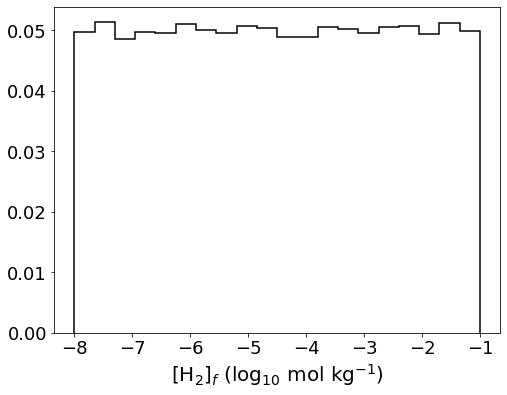

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
N = len(priors_neat)
Nbins=20
bins = np.linspace(np.min(priors_neat['logH2f']),np.max(priors_neat['logH2f']),Nbins+1)
counts_all,bins_all = np.histogram(priors_neat['logH2f'],bins=bins)
ax.hist(bins_all[:-1], bins_all, weights=counts_all/N,color='k',lw=1.5,histtype='step')
#ax.hist(np.log10(priors['H2f']),histtype='step',color='k',lw=1.5,bins=20,density=True)


#cplt.DistriPlot(ax,priors_neat,var='logH2f',Nbins=20,alpha=1,histtype='step',linewidth=1.5)
ax.tick_params(labelsize=18)
ax.set_xlabel('$[\mathregular{H}_2]_f$ ($\log_{10}$ $\mathregular{mol}~\mathregular{kg}^{-1}$)',fontsize=20)
plt.savefig('prior_all.png',dpi=400,bbox_inches='tight')
plt.show()

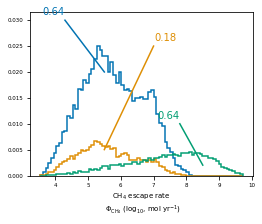

In [22]:
# Plot distribution of observables, separated into I,H,not H at scale
fig, ax = plt.subplots(figsize=(4,3))
var = 'FCH4'
cplt.DistriPlot(ax,total_table,var,Nbins=75,alpha=1,histtype='step',linewidth=1.5)


ax.plot([5.5,4.3],[0.02,0.03],color=palette[0])
ax.text(4.29,0.031,'0.64',color=palette[0],ha='right')

ax.plot([5.5,7],[0.005,0.025],color=palette[1])
ax.text(7.01,0.026,'0.18',color=palette[1])

ax.plot([8.5,7.8],[0.002,0.01],color=palette[2])
ax.text(7.79,0.011,'0.64',color=palette[2],ha='right')


plt.xlabel(labels[var])
plt.show()

## Build a Random Forest model classifier and estimate posterior probabilities of "habitable", "inhabited" and "uninhabitable"

Very useless in this case since both abiotic models have zero likelihood

In [11]:
# Building the RF classifier
rfcl = RandomForestClassifier(random_state=0,n_estimators=500,criterion='gini',max_depth=20,
                              max_features=3,warm_start=False,min_samples_leaf=10,min_samples_split=100,
                              bootstrap=True,max_leaf_nodes=None,oob_score=True)

In [12]:
# Train the classifier
rfcl.fit(training_df, reftable_ref)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [13]:
rfcl.classes_

array(['habitable', 'inhabited', 'uninhabitable'], dtype='<U13')

In [14]:
# Classifier score
rfcl.score(test_df,testtable_ref)

0.9311

In [15]:
# Prediction on data
rfcl.predict(observations)

array(['inhabited', 'inhabited'], dtype='<U13')

In [16]:
# Posterior probability estimate
probs = rfcl.predict_proba(observations)
mprob = np.mean(probs,axis=0)
mprob
# [habitable,inhabited,uninhabitable]

array([0., 1., 0.])

In [17]:
# Manual cross-validation
#technically, the score function is a cross validation on boot-strapped training samples, see Pudlo et al, here we also cross-valid on a separate table
crossvalid = rfcl.predict(test_df)

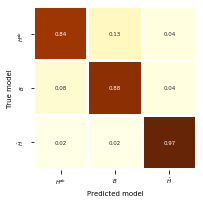

In [51]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
matrix = metrics.confusion_matrix(testtable_ref,crossvalid)
ticks = [r'$H^{ab}$',r'$B$',r'$\bar{H}$']
sns.heatmap(np.round(matrix/np.repeat(np.sum(matrix,axis=1),3).reshape(3,3),2),annot=True,square=True,cmap='YlOrBr',
            linecolor='white',linewidths=2,cbar=False,xticklabels=ticks,yticklabels=ticks,ax=ax,annot_kws={'fontsize':5.5})
ax.set_ylabel('True model')
ax.set_xlabel('Predicted model')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.savefig('figures/confusion.svg',dpi=400,bbox_inches='tight')
plt.show()

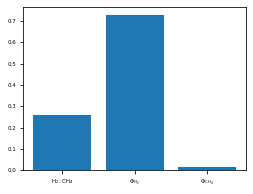

In [19]:
# Feature importance in RF classifier
plt.figure(figsize=(4,3))
plt.bar([r'$\mathregular{H_2}:\mathregular{CH_4}$',r'$\Phi_{\mathregular{H_2}}$',r'$\Phi_{\mathregular{CH_4}}$'],rfcl.feature_importances_)
plt.show()

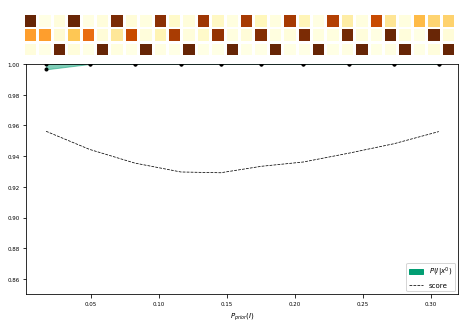

In [20]:
fig  = plt.figure(figsize=(6,4))
ax   = plt.axes([0.1,0,1,0.8])
MinP = np.min(np.array(bootstrap['probabilities'])[:,:,1],axis=1)
MaxP = np.max(np.array(bootstrap['probabilities'])[:,:,1],axis=1)
ax.plot(bootstrap['PI'],MinP,'k.')
ax.plot(bootstrap['PI'],MaxP,'k.')
ax.plot(bootstrap['PI'],bootstrap['score'],'--k',linewidth=0.75)
ax.fill_between(bootstrap['PI'],MaxP,MinP,color=palette[2],alpha=0.5)
ax.set_ylim(0.85,1.00)

handles = [mpatches.Patch(color=palette[2])]
handles.append(mlines.Line2D([], [], color='k',linestyle='--', linewidth=0.75))
ax.legend(handles=handles,labels=[r'$P(I|x^0)$','score'],loc='lower right')
ax.set_xlabel(r'$P_{prior}(I)$')
ticks=[]
width    = (1/len(bootstrap['confusion']))*2
Xcoords  = np.linspace(0.11,1.01,len(bootstrap['confusion'])) - width/3
for i in range(len(bootstrap['confusion'])):
    m = bootstrap['confusion'][i]
    yticks = ticks
    if i > 0:
        yticks = []
    ax2 = plt.axes([Xcoords[i],0.8,width,width])
    sns.heatmap(m,ax=ax2,annot=False,square=True,cmap='YlOrBr',
                linecolor='white',linewidths=2,cbar=False,annot_kws={'fontsize':6},
                xticklabels=ticks,yticklabels=yticks)
    bottom, top = ax2.get_ylim()
    ax2.set_ylim(bottom + 0.5, top - 0.5)
#plt.tight_layout()
#plt.savefig('figures/bootstrap.png',dpi=400,bbox_inches = 'tight')

In [21]:
inhabited_data = total_table[total_table['model']==2][['R1','FH2','FCH4']]
homestats.get_Nli_range(inhabited_data,'FCH4',logobservations)

{'var': 'FCH4',
 'NL': 0.5281961192836259,
 'maxL': 8.11615676588282,
 'width': 0.2385606273598313,
 'obs': array([8.7998366 , 9.27695786]),
 'kernel': <scipy.stats.kde.gaussian_kde at 0x130971910>}

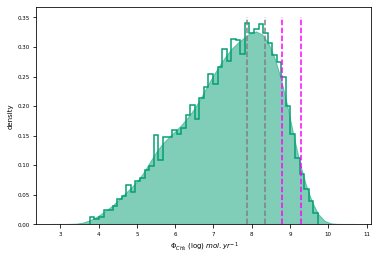

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
cplt.plot_Likelihood(ax,inhabited_data,'FCH4',logobservations,
                topval=0.35,histtype='step',density=True,bins=50,color=palette[2],linewidth=1.5)
ax.set_xlabel(r'$\Phi_{CH_4}$ (log) $mol.yr^{-1}$')
ax.set_ylabel('density')
plt.show()

In [25]:
def Likelihood(outputs,observations,observables,scale):
    """
    Returns the so-called normalized likelihoods (an estimate)
    of the different models given observations
    """
    Likelyhood = []
    for var in observables:
        distr = np.array(outputs[var])
        Lfun = stats.gaussian_kde(distr)
        Lfun_weighed = lambda x : Lfun(x)*scale
        xobsmin = np.min(observations[var])
        xobsmax = np.max(observations[var])
        e = (xobsmax-xobsmin)/2
        xobs = np.mean(observations[var])
        NLi  = scint.quad(Lfun_weighed,xobs-e,xobs+e)[0]
        if NLi >1:
            print('warning : N Likelyhood greater than 1 ({})! This may be due to numerical integration'.format(NLi))
            NLi = 1.0
        Likelyhood.append(NLi)
    return(Likelyhood)

def autolabel(rects,bottom,fontsize,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()+bottom
        if height < 0.01 and height > 0.001:
            text = '< 1%'
        elif height < 0.001:
            text = r'$\approx 0$'
        else:
            text = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(text),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1.5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=fontsize)

In [26]:
var_order = np.array(['FH2','FCH4','R1'])
#var_order = list(logobservations.keys())
PI = len(total_table[total_table['model']==2])/len(total_table)
PH = len(total_table[total_table['model']==1])/len(total_table)
PU = len(total_table[total_table['model']==0])/len(total_table)

inh_L = np.array(Likelihood(total_table[total_table['model']==2],logobservations,observables=var_order,scale=PI))
hab_L = np.array(Likelihood(total_table[total_table['model']==1],logobservations,observables=var_order,scale=PH))
uni_L = np.array(Likelihood(total_table[total_table['model']==0],logobservations,observables=var_order,scale=PU))

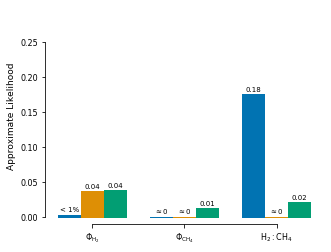

In [27]:
mpl.rc('axes', labelsize=9)
mpl.rc('xtick', labelsize=8)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=8)
fig,ax =plt.subplots(figsize=(5,4))
Xticks = [labelsDict[k] for k in var_order]
X = np.array([1,2,3])
width=0.25
bottom = -0.001
Urect = ax.bar(X-width,uni_L-bottom,width=width,color=palette[0],bottom=bottom)
Hrect = ax.bar(X,hab_L-bottom,width=width,color=palette[1],bottom=bottom)
Irect = ax.bar(X+width,inh_L-bottom,width=width,color=palette[2],bottom=bottom)
f = 7
autolabel(Urect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Hrect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Irect,bottom=bottom,fontsize=f,ax=ax)
ax.set_xticks([1,2,3])
ax.set_xticklabels(Xticks)
ax.set_ylim(-0.01,.3)
sns.despine(ax=ax,trim=True,left=False)
ax.set_ylabel('Approximate Likelihood')
#plt.savefig(os.path.join(rootdir,'figures','likelihood05.svg'),dpi=400)
plt.show()

In [29]:
labelsDict =  {'FH2' :'$\mathregular{H_2} $ escape rate \n $\Phi_{\mathregular{H_2} }$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCO2':'$\mathregular{CO_2}$ escape rate \n $\Phi_{\mathregular{CO_2}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCH4':'$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'R1':'gas ratio \n $\mathregular{H_2}:\mathregular{CH_4}$, ($\log_{10}$)',
           'R2':r'$R_2$',
           'H2f':'HF $\mathregular{H_2}$ \n $[\mathregular{H_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2f':'HF $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4f':'HF $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'H2o' :'Ocean $\mathregular{H_2}$ \n $[\mathregular{H_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2o':'Ocean $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4o':'Ocean $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'Tf':'HF temperature \n $T_f$ (K)'}

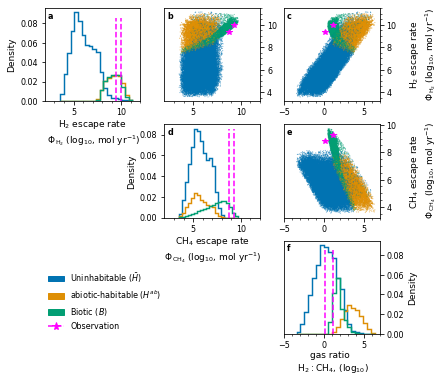

In [41]:
fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(6,6),constrained_layout=False)
gs = fig.add_gridspec(3, 3)

variables = ['FH2','FCH4','R1']
barlabels = np.array([r'$H^{ab}$',r'$I$',r'$\bar{H}$'])
palette = sns.color_palette('colorblind')
colors=[palette[total_table['model'].iloc[k]] for k in range(len(total_table))]

for i in range(3):
    for j in range(3):
        var = variables[i]
        var2 = variables[j]
        if var2 == 'R1':
            axes[i,j].set_xlim(-5,7)
        else:
            axes[i,j].set_xlim(2,12)
        if i==j:
            cplt.DistriPlot(ax=axes[i,j],data=total_table,var=var,Nbins=20,alpha=1,histtype='step',linewidth=1.45,palette=palette)
            axes[i,j].set_xlabel(labelsDict[var],labelpad=1)
            axes[i,j].plot([logobservations[var]]*2,[0,0.085],linestyle='--',color='magenta')
        elif i < j:
            axes[i,j].scatter(total_table[var2],total_table[var],c=colors,marker='d',s=0.01,rasterized=True)
            axes[i,j].plot(logobservations[var2],logobservations[var],marker='*',linestyle='',color='magenta')
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        
axes[2,0].axis('off')
axes[2,1].axis('off')
axes[1,0].axis('off')

axes[0,0].set_ylabel('Density')
axes[0,1].yaxis.tick_right()
axes[0,2].yaxis.tick_right()
axes[0,2].yaxis.set_label_position("right")
axes[0,2].set_ylabel(labelsDict[variables[0]])
axes[1,1].set_ylabel('Density')
axes[1,2].yaxis.tick_right()
axes[1,2].yaxis.set_label_position("right")
axes[1,2].set_ylabel(labelsDict[variables[1]])

axes[2,2].yaxis.tick_right()
axes[2,2].yaxis.set_label_position("right")
axes[2,2].set_ylabel('Density')



cols  = [0,1,2]*2+ [0,2]
xlabc = [0.135,0.41,0.69]*2+[0.13,0.69]
rows  = np.repeat([0,1,2],[3,3,2])
ylabc = np.repeat([0.855,0.58,0.32,0.31],[3,3,1,1])

ax_boot = fig.add_subplot(gs[2,:2])
axes[2,1] = ax_boot
ax_boot.axis('off')
#width=0.3
#X = np.array([1,2,3])
#bottom = -0.001
#Urect = ax_boot.bar(X-width,uni_L-bottom,width=width,color=palette[0],bottom=bottom)
#Hrect = ax_boot.bar(X,hab_L-bottom,width=width,color=palette[1],bottom=bottom)
#Irect = ax_boot.bar(X+width,inh_L-bottom,width=width,color=palette[2],bottom=bottom)
#f = 6
#autolabel(Urect,bottom=bottom,fontsize=f,ax=ax_boot)
#autolabel(Hrect,bottom=bottom,fontsize=f,ax=ax_boot)
#autolabel(Irect,bottom=bottom,fontsize=f,ax=ax_boot)

#ax_boot.set_ylim(-0.01,.3)
#ax_boot.set_xticks(X)
#ax_boot.set_xticklabels(Xticks,rotation=0,ha='center',fontsize=7)
#ax_boot.tick_params(axis='x', which='major', pad=12)
#ax_boot.set_ylabel('Likelihood')
#sns.despine(ax=ax_boot,trim=True,left=False)

labels = ['{0}'.format(letter) for letter in ['a','b','c','','d','e','','f']]
for i,j,z in [(0,0,0),(0,1,1),(0,2,2),(1,1,4),(1,2,5),(2,1,6),(2,2,7)]:
    axes[i,j].text(0.03,0.89,labels[z],transform=axes[i,j].transAxes,fontsize=8,weight='bold')
    
axes[0,1].yaxis.set_minor_locator(AutoMinorLocator())
axes[0,2].yaxis.set_minor_locator(AutoMinorLocator())
axes[1,2].yaxis.set_minor_locator(AutoMinorLocator())

uninh_patch = mpatches.Patch(color=palette[0], label=r'Uninhabitable ($\bar{H}$)')
habit_patch = mpatches.Patch(color=palette[1], label=r'abiotic-habitable ($H^{ab}$)')
inhab_patch = mpatches.Patch(color=palette[2], label=r'Biotic ($B$)')
datap_line  = mlines.Line2D([], [], color='magenta', marker='*', linestyle='--', markersize=8, label='Observation')

axes[2,0].legend(handles = [uninh_patch, habit_patch, inhab_patch, datap_line],
                 fontsize=8,loc='lower left', borderaxespad=0, frameon=False)

fig.align_labels(axes[:,2])

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('figures/distributions_likelihood.png',dpi=400,bbox_inches = 'tight')
plt.show()

In [31]:
reftable_data_005 = np.load(os.path.join(rootdir,"reftable_data_005.npy"),allow_pickle=True).item()
reftable_ref_005 = np.load(os.path.join(rootdir,"reftable_ref_005.npy"),allow_pickle=True)
testtable_data_005 = np.load(os.path.join(rootdir,"testtable_data_005.npy"),allow_pickle=True).item()
testtable_ref_005 = np.load(os.path.join(rootdir,"testtable_ref_005.npy"),allow_pickle=True)

total_table_005 = pd.read_csv(os.path.join(rootdir,"total_table.csv"),delimiter=';')
training_df_005 = pd.DataFrame(data=reftable_data)
test_df_005 = pd.DataFrame(data=testtable_data)

total_table_005 = np.log10(pd.DataFrame(data=reftable_data_005))
total_table_005['models'] = reftable_ref_005
translate = {'uninhabitable':0,'habitable':1,'inhabited':2}
total_table_005['model'] = np.array([translate[total_table_005['models'].loc[i]] for i in range(len(total_table_005))])

In [32]:
var_order = np.array(['FH2','FCH4','R1'])
#var_order = list(logobservations.keys())
PI005 = len(total_table_005[total_table_005['model']==2])/len(total_table_005)
PH005 = len(total_table_005[total_table_005['model']==1])/len(total_table_005)
PU005 = len(total_table_005[total_table_005['model']==0])/len(total_table_005)
inh_L = np.array(Likelihood(total_table_005[total_table_005['model']==2],logobservations,observables=var_order,scale=PI005))
hab_L = np.array(Likelihood(total_table_005[total_table_005['model']==1],logobservations,observables=var_order,scale=PH005))
uni_L = np.array(Likelihood(total_table_005[total_table_005['model']==0],logobservations,observables=var_order,scale=PU005))

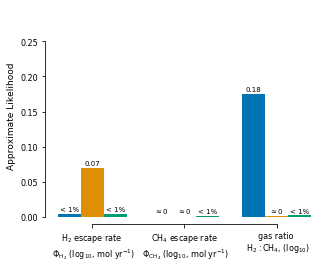

In [34]:
mpl.rc('axes', labelsize=9)
mpl.rc('xtick', labelsize=8)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=8)
fig,ax =plt.subplots(figsize=(5,4))
Xticks = [labelsDict[k] for k in var_order]
X = np.array([1,2,3])
width=0.25
bottom = -0.001
Urect = ax.bar(X-width,uni_L-bottom,width=width,color=palette[0],bottom=bottom)
Hrect = ax.bar(X,hab_L-bottom,width=width,color=palette[1],bottom=bottom)
Irect = ax.bar(X+width,inh_L-bottom,width=width,color=palette[2],bottom=bottom)
f = 7
autolabel(Urect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Hrect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Irect,bottom=bottom,fontsize=f,ax=ax)
ax.set_xticks([1,2,3])
ax.set_xticklabels(Xticks)
ax.set_ylim(-0.01,.3)
sns.despine(ax=ax,trim=True,left=False)
ax.set_ylabel('Approximate Likelihood')
#plt.savefig(os.path.join(rootdir,'figures','likelihood005.svg'),dpi=400)
plt.show()